$\textbf{Applications of Neural Networks to Banking Risk and Contagion}$

In previous sections we looked at banking risk and contagion with both range volatility as well as with quantile regression.  Now we will look at these measures of risk with the use of neural network approximation.  Since the quantile regression discussion is the most recent, we will start with that approach, but then we will examine the issue with the range volatility approach.

$\textit{Quantile Regression for Risk and Contagion}$

Lets to back and load in the data for the 20 GSIB's.  We do the original quantile regression but also a quantile regression with a simple feedforward neural network, of three neurons in one hidden layer.

In [1]:
clear all;
TAB1 = readtable('McNYet_May2020_CovarData.xlsx');
date1 = table2array(TAB1(:,1));
StateVar  = table2array(TAB1(:,2:10));
SharePrice = table2array(TAB1(:,11:30));
TraceVol = table2array(TAB1(:,31:50));
MarketCap = table2array(TAB1(:,51:70));
index = 6:5:length(StateVar); index = index';
index1 = 1:5:length(StateVar); index1 = index1';
StateVar1 = StateVar(index1,:);
StateVar1 = StateVar1(1:end-1,:);
MarketCap2 = MarketCap(index1,:);
for i = 2:length(MarketCap2(:,7)), 
    if MarketCap2(i,7) == 0, 
        MarketCap2(i,7) = MarketCap2(i-1,7); 
    end; 
end;

Return = diff(log(MarketCap2));
Return = - Return;

MarketCap2 = MarketCap2(2:end,:);
SMC2 = sum(MarketCap2,2);
SMC3 = kron(ones(1,20), SMC2);
RatioMC = MarketCap2./SMC3;
AveReturn1 = -Return .* RatioMC;
WeightedReturn = sum(AveReturn1,2);


date2 = date1(index1,:);
date2 = date2(2:end,:);

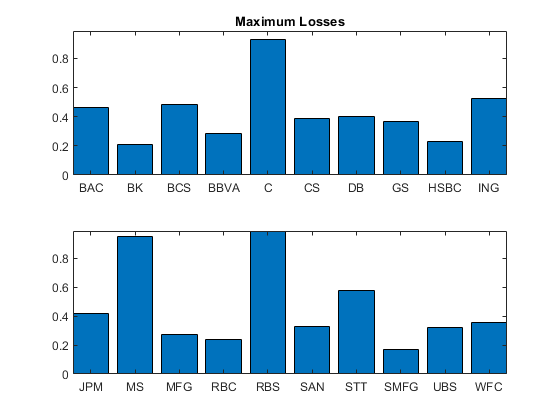

In [2]:
BankNames1 = {'BAC','BK','BCS','BBVA', 'C', 'CS', 'DB', 'GS', 'HSBC', 'ING','JPM', 'MS', ...
    'MFG', 'RBC', 'RBS', 'SAN', 'STT', 'SMFG', 'UBS,' 'WFC'};
BankNames2 = char(BankNames1);
MaxRet = max(Return); 
a1 =subplot(211); ...
bar(MaxRet(1:10)); axis([1,10, -1,1]);axis tight; title('Maximum Losses');...
names = {'BAC';'BK';'BCS';'BBVA'; 'C'; 'CS'; 'DB'; 'GS'; 'HSBC'; 'ING'}; ...
set(gca,'xtick',[1:10],'xticklabel',names);...
a2 = subplot(212); ...
bar(MaxRet(11:20)); axis([1,10,-1,1]); axis tight;...
names1 = {'JPM'; 'MS'; ,'MFG'; 'RBC'; 'RBS'; 'SAN'; 'STT'; 'SMFG'; 'UBS'; 'WFC'};
set(gca,'xtick',[1:10],'xticklabel',names1);
linkaxes([a1, a2], 'y');
saveas(gcf, 'Week6_Fig1.eps', 'eps');

In [3]:
tic;
for i = 1:20,
    RETURN = Return;
    MARKETCAP2 = MarketCap2;
    RETURN(:,i) = [];
    MARKETCAP2(:,i) = [];
    WRETURN1 = RETURN.*MARKETCAP2;
    SRETURN1 = sum(MARKETCAP2,2);
    SRETURN2 = kron(ones(1,19), SRETURN1);
    SYSTEMRET = WRETURN1./SRETURN2;  
    SYSTEMRET = sum(SYSTEMRET,2);
    xx = [Return(:,i) StateVar1];
    yy = SYSTEMRET;
    % clear RETURN MARKETCAP2;
    %  p,stats]=quantreg(x,y,tau[,order,nboot]);
    tau1= .95;
    tau2 = .50;
    nst = [3];
    [yhat05, INFOC05] = netquantile1(xx,yy,tau1,nst);
    [yhat50, INFOC50] = netquantile1(xx,yy,tau2,nst);
    INFOC(:,i) = mean(INFOC05 + INFOC50,2);
    DCOVARnet(:,i) = yhat05 - yhat50;
    nst = 20;
    [yhat05, INFOC05] = netquantile1(xx,yy,tau1,nst);
    [yhat50, INFOC50] = netquantile1(xx,yy,tau2,nst);
    INFOC1(:,i) = mean(INFOC05 + INFOC50,2);
    DCOVARnet1(:,i) = yhat05 - yhat50;
    nst = [20 10 5];
    [yhat05, INFOC05] = netquantile1(xx,yy,tau1,nst);
    [yhat50, INFOC50] = netquantile1(xx,yy,tau2,nst);
    INFOC2(:,i) = mean(INFOC05 + INFOC50,2);
    DCOVARnet2(:,i) = yhat05 - yhat50;
    nst = [20 15 10 5];
    [yhat05, INFOC05] = netquantile1(xx,yy,tau1,nst);
    [yhat50, INFOC50] = netquantile1(xx,yy,tau2,nst);
    INFOC3(:,i) = mean(INFOC05 + INFOC50,2);
    DCOVARnet3(:,i) = yhat05 - yhat50;
    end;
    toc;
    runtime = toc/60;



Elapsed time is 772.899902 seconds.



In [ ]:
runtime



In [ ]:
INFOCmean = mean(INFOC,2);
INFOC1mean = mean(INFOC1,2); INFOC2mean = mean(INFOC2,2);  INFOC3mean = mean(INFOC3,2);
[INFOCmean INFOC1mean INFOC2mean INFOC3mean]

In [96]:
INFOCRIT_Quantile = [INFOCmean INFOC1mean INFOC2mean INFOC3mean];
T1 = {'AIF'; 'BIF'; 'HQIF'};
T1 = cell2table(T1);
T2 = [INFOCRIT_Quantile];
T2 = array2table(T2);

T2.Properties.VariableNames([1:4])={ '3', '20' '20-10-5' '20-15-10-5'};
T2.Properties.RowNames = {'AIC', 'BIC', 'HQIF'};
writetable(T2,'Week6_Tab1.xlsx');

We see by all three information criteria (AIC, BIC, HQIC) that the simplest neural net structure does best.

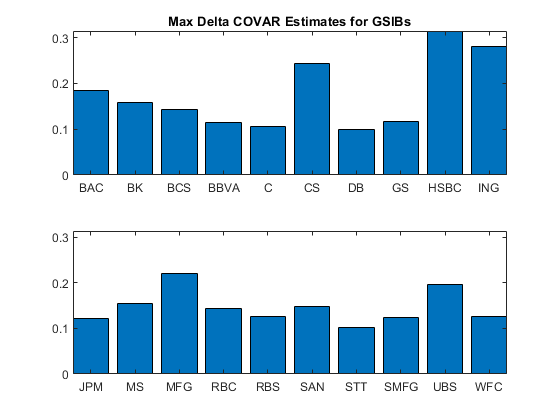

In [38]:
Maxval = max(DCOVARnet);
a1 =subplot(211); ...
bar(Maxval(1:10)); axis([1,10, -1,1]);axis tight;...
title('Max Delta COVAR Estimates for GSIBs');...
names = {'BAC';'BK';'BCS';'BBVA'; 'C'; 'CS'; 'DB'; 'GS'; 'HSBC'; 'ING'}; ...
set(gca,'xtick',[1:10],'xticklabel',names);...
a2 = subplot(212); ...
bar(Maxval(11:20)); axis([1,10,-1,1]); axis tight; ...
names1 = {'JPM'; 'MS'; ,'MFG'; 'RBC'; 'RBS'; 'SAN'; 'STT'; 'SMFG'; 'UBS'; 'WFC'};
set(gca,'xtick',[1:10],'xticklabel',names1);
linkaxes([a1, a2], 'y');
saveas(gcf, 'Week6_Fig2.eps', 'eps');





We see that C, RBS, SAN, followed by UBS, lead the pack, for their negative max impact values on the financial system.  However their mean values are about the same.

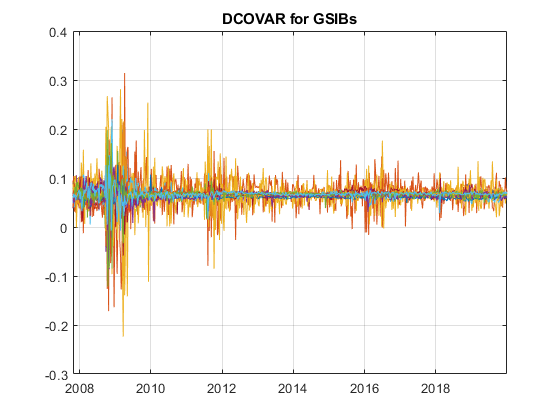

In [101]:
plot(date2, DCOVARnet);  title('DCOVAR for GSIBs'); grid;
saveas(gcf, 'Week6_DOVAR.epsc','epsc');

In [161]:

for i = 1:20,
[maxval(i), index(i)] = max(DCOVARnet(:,i));
DATE1(i) = date2(index(i));
end;
DATE2 = array2table(DATE1');
DATE3 =  table2cell(DATE2);









BankNames11 = {'BAC';'BK';'BCS';'BBVA'; 'C'; 'CS'; 'DB'; 'GS'; 'HSBC'; 'ING';'JPM'; 'MS'; ...
    'MFG'; 'RBC'; 'RBS'; 'SAN'; 'STT'; 'SMFG'; 'UBS'; 'WFC'};
TB1 = cell2table(BankNames11);
size(TB1)
size(DATE2)

TB2 = [DATE2 TB1];

TB2.Properties.VariableNames([1:2]) = {'Date','GSIB Bank'};
TB2;
writetable(TB2,'Week6_Tab2.xlsx');












ans =

    20     1


ans =

    20     1




Lets split the sample in half, to see if the contagion effect differ between more turbulent and more tranquil periods.

In [3]:
who


Your variables are:

AveReturn1      MarketCap2      SMC2            StateVar1       a1              i               names1          
BankNames1      MaxRet          SMC3            TAB1            a2              index           
BankNames2      RatioMC         SharePrice      TraceVol        date1           index1          
MarketCap       Return          StateVar        WeightedReturn  date2           names           




In [8]:
tic;
split = 307;
for i = 1:20,
    RETURN = Return(1:split,:);
    MARKETCAP2 = MarketCap2(1:split,:);
    RETURN(:,i) = [];
    MARKETCAP2(:,i) = [];
    WRETURN1 = RETURN.*MARKETCAP2;
    SRETURN1 = sum(MARKETCAP2,2);
    SRETURN2 = kron(ones(1,19), SRETURN1);
    SYSTEMRET = WRETURN1./SRETURN2;  
    SYSTEMRET = sum(SYSTEMRET,2);
     
    xx = [Return(1:split,i) StateVar1(1:split,:)];
    yy = SYSTEMRET;
    % clear RETURN MARKETCAP2;
    %  p,stats]=quantreg(x,y,tau[,order,nboot]);
    tau1= .95;
    tau2 = .50;
    nst = [3];
    [yhat05, infoc05] = netquantile1(xx,yy,tau1,nst);
    [yhat50, infoc50] = netquantile1(xx,yy,tau2,nst);
    INFOC1(:,i) = infoc05 + infoc50;
    DCOVAR_GFC(:,i) = yhat05 - yhat50;
    clear xx yy RETURN MARKETCAP2 WRETURN1 SRETURN1 SRETURN2 SYSTEMRET;
end;
INFOC1mean = mean(INFOC1,2);
toc;
runtime = toc/60;
runtime


Elapsed time is 138.716627 seconds.

runtime =

    2.3120




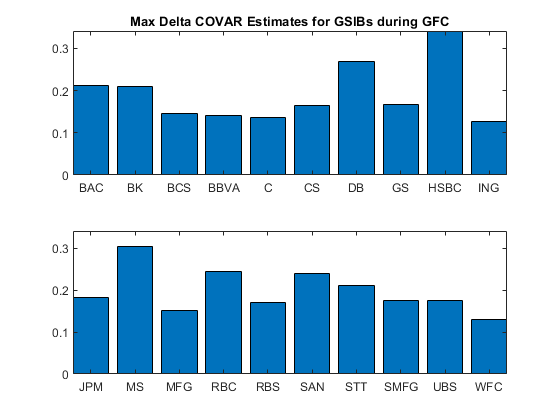

In [10]:
Maxval = max(DCOVAR_GFC);
a1 =subplot(211); ...
bar(Maxval(1:10)); axis([1,10, -1,1]);axis tight;...
title('Max Delta COVAR Estimates for GSIBs during GFC');...
names = {'BAC';'BK';'BCS';'BBVA'; 'C'; 'CS'; 'DB'; 'GS'; 'HSBC'; 'ING'}; ...
set(gca,'xtick',[1:10],'xticklabel',names);...
a2 = subplot(212); ...
bar(Maxval(11:20)); axis([1,10,-1,1]); axis tight; ...
names1 = {'JPM'; 'MS'; ,'MFG'; 'RBC'; 'RBS'; 'SAN'; 'STT'; 'SMFG'; 'UBS'; 'WFC'};
set(gca,'xtick',[1:10],'xticklabel',names1);
linkaxes([a1, a2], 'y');
saveas(gcf, 'Week6_Fig3.eps', 'eps');

We see that HSBC leads the pack at the time of the GFC, but DB and MS also have strong effects.  Let's see what happens after the GFC period.

In [11]:
tic;
split = 307;
for i = 1:20,
    RETURN = Return(split+1:end,:);
    MARKETCAP2 = MarketCap2(split+1:end,:);
    RETURN(:,i) = [];
    MARKETCAP2(:,i) = [];
    WRETURN1 = RETURN.*MARKETCAP2;
    SRETURN1 = sum(MARKETCAP2,2);
    SRETURN2 = kron(ones(1,19), SRETURN1);
    SYSTEMRET = WRETURN1./SRETURN2;  
    SYSTEMRET = sum(SYSTEMRET,2);
     
    xx = [Return(split+1:end,i) StateVar1(split+1:end,:)];
    yy = SYSTEMRET;
    % clear RETURN MARKETCAP2;
    %  p,stats]=quantreg(x,y,tau[,order,nboot]);
    tau1= .95;
    tau2 = .50;
    nst = [3];
    [yhat05, infoc05] = netquantile1(xx,yy,tau1,nst);
    [yhat50, infoc50] = netquantile1(xx,yy,tau2,nst);
    INFOC1(:,i) = infoc05 + infoc50;
    DCOVAR_PostGFC(:,i) = yhat05 - yhat50;
    clear xx yy RETURN MARKETCAP2 WRETURN1 SRETURN1 SRETURN2 SYSTEMRET;
end;
INFOC1mean = mean(INFOC1,2);
toc;
runtime = toc/60;
runtime


Elapsed time is 140.629908 seconds.

runtime =

    2.3438




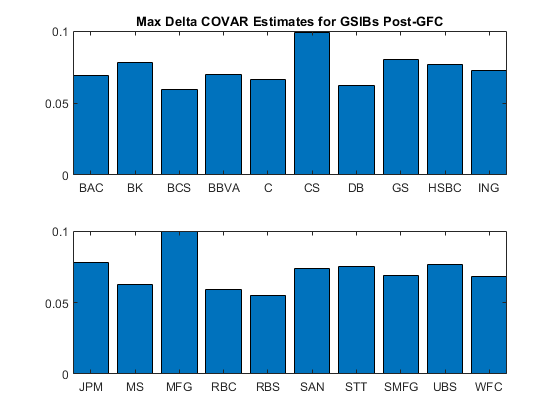

In [12]:
Maxval = max(DCOVAR_PostGFC);
a1 =subplot(211); ...
bar(Maxval(1:10)); axis([1,10, -1,1]);axis tight;...
title('Max Delta COVAR Estimates for GSIBs Post-GFC');...
names = {'BAC';'BK';'BCS';'BBVA'; 'C'; 'CS'; 'DB'; 'GS'; 'HSBC'; 'ING'}; ...
set(gca,'xtick',[1:10],'xticklabel',names);...
a2 = subplot(212); ...
bar(Maxval(11:20)); axis([1,10,-1,1]); axis tight;...
names1 = {'JPM'; 'MS'; ,'MFG'; 'RBC'; 'RBS'; 'SAN'; 'STT'; 'SMFG'; 'UBS'; 'WFC'};
set(gca,'xtick',[1:10],'xticklabel',names1);
linkaxes([a1, a2], 'y');
saveas(gcf, 'Week6_Fig4.eps', 'eps');

In the post_GFC era, the maximum $\Delta$COVAR effects are greatly reduced, with the max value about one-third of the max value in the GFC period. The leaders are CS ad MFG, but HSBS also is high, along with UBS.  Let's see when the max values took place.

In [14]:
for i = 1:20,
[maxval(i), index(i)] = max(DCOVAR_PostGFC(:,i));
DATE1(i) = date2(index(i));
end;
DATE2 = array2table(DATE1');
DATE3 =  table2cell(DATE2);
BankNames11 = {'BAC';'BK';'BCS';'BBVA'; 'C'; 'CS'; 'DB'; 'GS'; 'HSBC'; 'ING';'JPM'; 'MS'; ...
    'MFG'; 'RBC'; 'RBS'; 'SAN'; 'STT'; 'SMFG'; 'UBS'; 'WFC'};
TB1 = cell2table(BankNames11);
size(TB1)
size(DATE2)

TB2 = [DATE2 TB1];

TB2.Properties.VariableNames([1:2]) = {'Date','GSIB Bank'};
TB2;
writetable(TB2,'Week6_Tab3.xlsx');
TB2


ans =

    20     1


ans =

    20     1


TB2 =

  20x2 table

       Date        GSIB Bank
    ___________    _________

    23-Mar-2010    {'BAC' } 
    25-May-2012    {'BK'  } 
    27-Jul-2010    {'BCS' } 
    17-Jan-2011    {'BBVA'} 
    30-Nov-2010    {'C'   } 
    23-Mar-2012    {'CS'  } 
    16-Nov-2010    {'DB'  } 
    25-Feb-2013    {'GS'  } 
    10-Aug-2009    {'HSBC'} 
    24-Aug-2010    {'ING' } 
    16-Feb-2010    {'JPM' } 
    02-Feb-2010    {'MS'  } 
    23-Mar-2012    {'MFG' } 
    06-Apr-2012    {'RBC' } 
    14-Feb-2011    {'RBS' } 
    30-Mar-2010    {'SAN' } 
    30-Nov-2012    {'STT' } 
    13-May-2013    {'SMFG'} 
    03-Aug-2010    {'UBS' } 
    21-Dec-2010    {'WFC' } 




In [19]:
tic;
for i = 1:20,
    RETURN = Return;
    MARKETCAP2 = MarketCap2;
    RETURN(:,i) = [];
    MARKETCAP2(:,i) = [];
    WRETURN1 = RETURN.*MARKETCAP2;
    SRETURN1 = sum(MARKETCAP2,2);
    SRETURN2 = kron(ones(1,19), SRETURN1);
    SYSTEMRET = WRETURN1./SRETURN2;  
    SYSTEMRET = sum(SYSTEMRET,2);
    xx = [Return(:,i) StateVar1];
    yy = SYSTEMRET;
    % clear RETURN MARKETCAP2;
    %  p,stats]=quantreg(x,y,tau[,order,nboot]);
    tau1= .95;
    tau2 = .50;
    nst = [10 5 2];
    [yhat05 hqif05] = netquantile(xx,yy,tau1,nst);
    [yhat50 hqif50] = netquantile(xx,yy,tau2,nst);
    DCOVARnet2(:,i) = yhat05 - yhat50;
    HQIF2(i) = hqif05 + hqif50;
end;
HQIF2mean = mean(HQIF2);
toc


Elapsed time is 460.937822 seconds.



In [20]:
[HQIFmean HQIF1mean HQIF2mean]


ans =

    0.0955    0.0958    2.1148




It looks like the simpler neural network beats the more complex ones for the quantile regression.
Nevertheless, best to look at the implications of the more complex one.

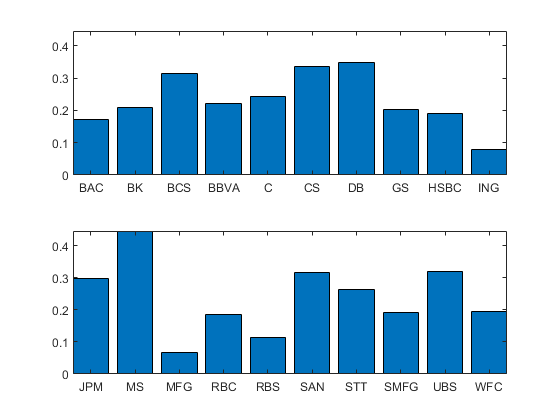

In [22]:
Maxval = max(DCOVARnet2);
a1 =subplot(211); ...
bar(Maxval(1:10)); axis([1,10, -1,1]);axis tight;...
names = {'BAC';'BK';'BCS';'BBVA'; 'C'; 'CS'; 'DB'; 'GS'; 'HSBC'; 'ING'}; ...
set(gca,'xtick',[1:10],'xticklabel',names);...
a2 = subplot(212); ...
bar(Maxval(11:20)); axis([1,10,-1,1]); axis tight;...
names1 = {'JPM'; 'MS'; ,'MFG'; 'RBC'; 'RBS'; 'SAN'; 'STT'; 'SMFG'; 'UBS'; 'WFC'};
set(gca,'xtick',[1:10],'xticklabel',names1);
linkaxes([a1, a2], 'y');

With the more complex network, MS stands at the top, along with BCS, CS, DB, UBS.  Lets try some more layers.   DB, of course, is famous for being highly fined for the LIBOR manipulation scandal.  Let's try four layers of ten neurons.  But this network by the HQIF criterion, is overfitted relative to the simple one layer network of 3 neurons.  So the parameters are likely picking up more interconnects than are warranted by the data.

In [26]:

tic;
for i = 1:20,
    RETURN = Return;
    MARKETCAP2 = MarketCap2;
    RETURN(:,i) = [];
    MARKETCAP2(:,i) = [];
    WRETURN1 = RETURN.*MARKETCAP2;
    SRETURN1 = sum(MARKETCAP2,2);
    SRETURN2 = kron(ones(1,19), SRETURN1);
    SYSTEMRET = WRETURN1./SRETURN2;  
    SYSTEMRET = sum(SYSTEMRET,2);
    xx = [Return(:,i) StateVar1];
    yy = SYSTEMRET;
    % clear RETURN MARKETCAP2;
    %  p,stats]=quantreg(x,y,tau[,order,nboot]);
    tau1= .95;
    tau2 = .50;
    nst = [10 10 10 ];
    [yhat05, hqif05] = netquantile(xx,yy,tau1,nst);
    [yhat50, hwif50]= netquantile(xx,yy,tau2,nst);
    DCOVARnet3(:,i) = yhat05 - yhat50;
    HQIF3(i) = hqif05+hqif50;
end;
HQIF3mean = mean(HQIF3);
toc;
runtime = toc;


Elapsed time is 501.932354 seconds.



In [29]:
[HQIFmean HQIF1mean HQIF2mean HQIF3mean]


ans =

    0.0955    0.0958    2.1148    3.0602




We see that going to the expansive 4-layered network does not help.  The Hannan-Quinn criterion tells us to accept the simpler one-layer network with three neurons.  Let's look at the last one.

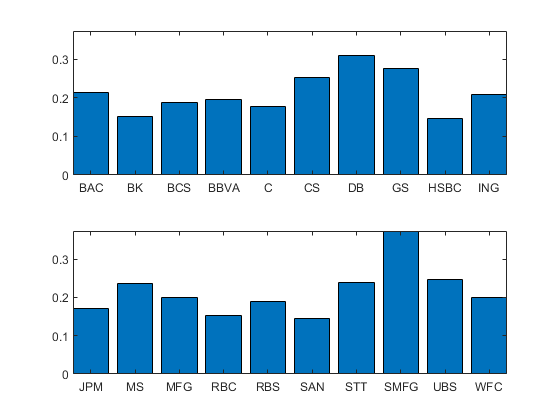

In [30]:
Maxval = max(DCOVARnet3);
a1 =subplot(211); ...
bar(Maxval(1:10)); axis([1,10, -1,1]);axis tight;...
names = {'BAC';'BK';'BCS';'BBVA'; 'C'; 'CS'; 'DB'; 'GS'; 'HSBC'; 'ING'}; ...
set(gca,'xtick',[1:10],'xticklabel',names);...
a2 = subplot(212); ...
bar(Maxval(11:20)); axis([1,10,-1,1]); axis tight;...
names1 = {'JPM'; 'MS'; ,'MFG'; 'RBC'; 'RBS'; 'SAN'; 'STT'; 'SMFG'; 'UBS'; 'WFC'};
set(gca,'xtick',[1:10],'xticklabel',names1);
linkaxes([a1, a2], 'y');

SMFB is now at the top, as well as DB.  But there are more nuisance parameters in this estimation, so the estimation may overstate the connectedness.

$\textit{Range Volatility and Contagion}$

Now lets turn to $\textit{daily}$ range volatility and evaluate contagion effects with various neural net specifications.

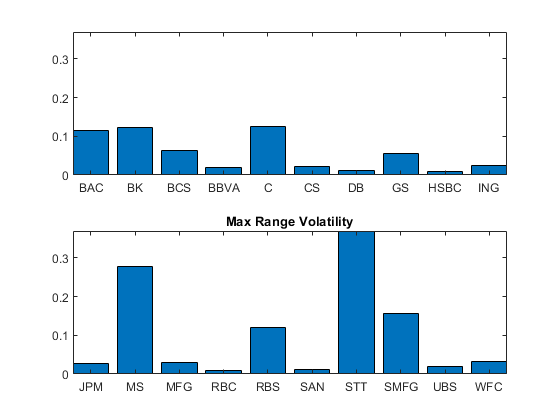

In [2]:
clear all;
TAB1 = readtable('McNelis_Yetman_May2020.xlsx');
date1 = TAB1(:,1);
date1 = table2array(date1);
date1 = datetime(date1);
dat_ = TAB1(:,2:21);
[ry, cy] = size(dat_);
xx = TAB1(:,22:end);
dat_= table2array(dat_);
xx = table2array(xx);
% dat1_ = (dat_ - min(dat_))./(max(dat_)-min(dat_));
% xx1 = (xx - min(xx))./(max(xx)-min(xx));
%dat_ = normalize(dat_);
% xx = normalize(xx);

%dat2_ =  2*dat1_ - 1;
%xx2 = 2 * xx1 - 1;

% dat_ = gpuArray(dat_,range');
% xx = gpuArray(xx);

BankNames = {'BAC'	'BK'	'BCS'	'BBVA' 'C' 'CS' 'DB' 'GS' 'HSBC' 'ING'	'JPM' 'MS' ...
    'MFG' 'RBC' 'RBS' 'SAN' 'STT' 'SMFG' 'UBS' 'WFC'};
Maxval = max(dat_);

a1 =subplot(211); ...
bar(Maxval(1:10)); axis([1,10, -1,1]);axis tight;...
names = {'BAC';'BK';'BCS';'BBVA'; 'C'; 'CS'; 'DB'; 'GS'; 'HSBC'; 'ING'}; ...
set(gca,'xtick',[1:10],'xticklabel',names);...
a2 = subplot(212); ...
bar(Maxval(11:20)); axis([1,10,-1,1]); axis tight; title('Max Range Volatility');...
names1 = {'JPM'; 'MS'; ,'MFG'; 'RBC'; 'RBS'; 'SAN'; 'STT'; 'SMFG'; 'UBS'; 'WFC'};
set(gca,'xtick',[1:10],'xticklabel',names1);
linkaxes([a1, a2], 'y');
saveas(gcf, 'RangeVol.eps','eps');




In [2]:
for i = 1:20,
[maxval(i), index(i)] = max(dat_(:,i));
DATE1(i) = date1(index(i));
end;
DATE2 = array2table(DATE1');
DATE3 =  table2cell(DATE2);
BankNames11 = {'BAC';'BK';'BCS';'BBVA'; 'C'; 'CS'; 'DB'; 'GS'; 'HSBC'; 'ING';'JPM'; 'MS'; ...
    'MFG'; 'RBC'; 'RBS'; 'SAN'; 'STT'; 'SMFG'; 'UBS'; 'WFC'};
TB11 = cell2table(BankNames11);
size(TB11)
size(DATE2)

TB21 = [DATE2 TB11];

TB21.Properties.VariableNames([1:2]) = {'Date','GSIB Bank'};
TB21;
writetable(TB21,'Week6_Tab4.xlsx');



ans =

    20     1


ans =

    20     1




Lets look at a Network with a single layer of 20 neurons.

In [3]:
tic;
dat_ = normalize(dat_,'range',[-1,1]);    % dat are the range volatilities of the 20 banks
xx = normalize(xx,'range',[-1,1]);
size(dat_);
size(xx);
%  xx are the controls
nnst = [20];
lagst = [1:5];
[VD, INWARD, OUTWARD,NET, IFCRIT] = NNVARfun3(dat_, xx, nnst, lagst);
nnst = [20 10];
lagst = [1:5];
[VD1, INWARD1, OUTWARD1,NET1, IFCRIT1] = NNVARfun3(dat_, xx, nnst, lagst);
nnst = [20 15 10]
[VD2, INWARD2, OUTWARD2,NET2, IFCRIT2] = NNVARfun3(dat_, xx, nnst, lagst);
nnst = [20 15 10 5]
[VD3, INWARD3, OUTWARD3,NET3, IFCRIT3] = NNVARfun3(dat_, xx, nnst, lagst);
[IFCRIT1 IFCRIT2 IFCRIT3]
toc;
runtime = toc/60

 

Starting parallel pool (parpool) using the 'local' profile ...
Connected to the parallel pool (number of workers: 4).

nnst =

    20    15    10


nnst =

    20    15    10     5


ans =

    2.2768    2.4567    2.4262

Elapsed time is 728.951664 seconds.

runtime =

   12.1492




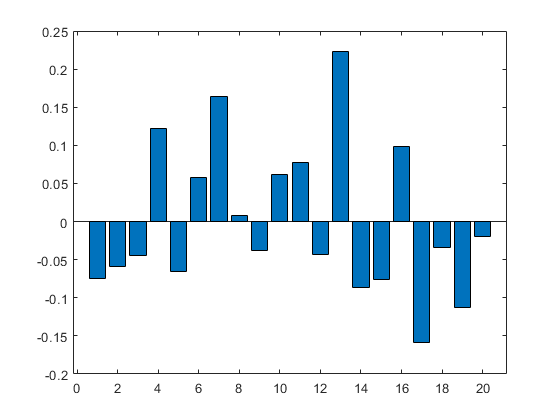

In [7]:
bar(NET3)

In [4]:
[IFCRIT IFCRIT1 IFCRIT2 IFCRIT3]




ans =

    2.2698    2.2768    2.4567    2.4262




In [44]:
size(dat_);
split = length(dat_)/2


split =

        1536




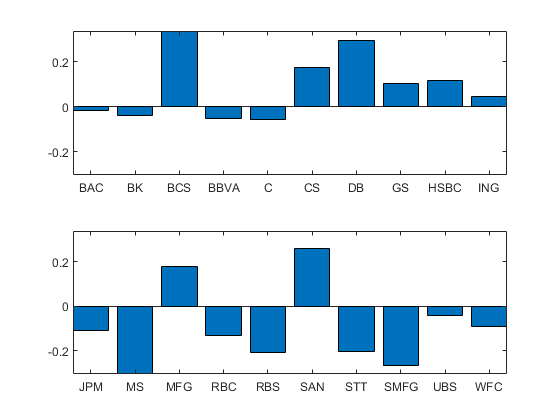

In [37]:
Maxval = NET;

a1 =subplot(211); ...
title('Net Outward Connectedness'); ...
bar(Maxval(1:10)); axis([1,10, -1,1]);axis tight;...
names = {'BAC';'BK';'BCS';'BBVA'; 'C'; 'CS'; 'DB'; 'GS'; 'HSBC'; 'ING'}; ...
set(gca,'xtick',[1:10],'xticklabel',names);...
a2 = subplot(212); ...
bar(Maxval(11:20)); axis([1,10,-1,1]); axis tight; ...
names1 = {'JPM'; 'MS'; ,'MFG'; 'RBC'; 'RBS'; 'SAN'; 'STT'; 'SMFG'; 'UBS'; 'WFC'};
set(gca,'xtick',[1:10],'xticklabel',names1);
linkaxes([a1, a2], 'y');
saveas(gcf, 'NN_NetConnect','eps');

In [42]:
VDD = VD';
adj2gephilab('BIS_NN20',VDD);
save BIS_NN_14October;


We see that BK, C, DB, SAN, and UBS are the largest transmitters of risk.

Lets see if the results are robust to a more complex network, of three hidden layers of [20 10 5]

In [50]:
size(date1)
split
datex = date1(split);
datex


ans =

        3072           1


split =

        1536


datex = 

  datetime

   21-Nov-2013




In [58]:
tic;
dat1 = dat_(1:split,:);
xx1 = xx(1:split,:);
dat2 = dat_(split+1:end,:);
xx2 = xx(split+1:end,:);
dat1_ = normalize(dat1,'range',[-1,1]);    % dat are the range volatilities of the 20 banks
xx1 = normalize(xx1,'range',[-1,1]);
dat2_ = normalize(dat2,'range',[-1,1]);    % dat are the range volatilities of the 20 banks
xx2 = normalize(xx2,'range',[-1,1]);

%  xx are the controls
nnst = [20];
lagst = [1:5];
[VD_1, INWARD_1, OUTWARD_1,NET_1, IFCRIT_1] = NNVARfun3(dat1_, xx1, nnst, lagst);
[VD_2, INWARD_2, OUTWARD_2,NET_2, IFCRIT_2] = NNVARfun3(dat2_, xx2, nnst, lagst);
toc;
runtime = toc/60


Elapsed time is 129.128782 seconds.

runtime =

    2.1522




In [72]:
[NET_1' NET_2']


ans =

   -0.2047    0.1255
    0.0435    0.9860
    0.1189   -0.2098
    0.0333    0.5374
   -0.0443   -0.3389
   -0.0201   -0.5923
    0.2791   -0.1329
   -0.0249   -0.0590
    0.0797   -0.4302
    0.1733    1.2858
    0.0444   -0.8234
    0.0163    0.0445
   -0.1696   -0.7290
   -0.0619   -0.6334
   -0.1916   -0.1449
    0.1072   -0.8791
   -0.0489   -0.8425
   -0.0120    2.1640
   -0.0629    0.3797
   -0.0551    0.2922




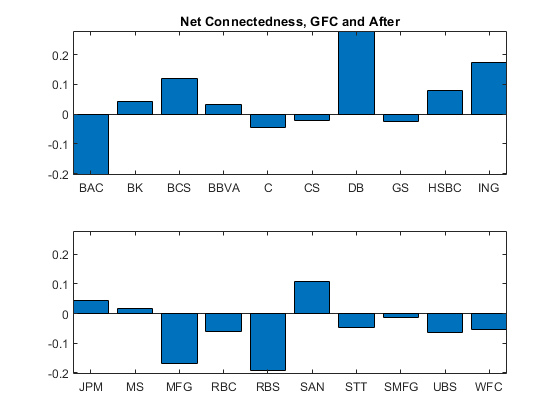

In [68]:
Maxval = NET_1;

subplot(211); ...
axval = NET_1;
a1 =subplot(211); ...
bar(Maxval(1:10)); axis([1,10, -1,1]);axis tight;...
title('Net Connectedness, GFC and After');...
names = {'BAC';'BK';'BCS';'BBVA'; 'C'; 'CS'; 'DB'; 'GS'; 'HSBC'; 'ING'}; ...
set(gca,'xtick',[1:10],'xticklabel',names);...
a2 = subplot(212); ...
bar(Maxval(11:20)); axis([1,10,-1,1]); axis tight;...
names1 = {'JPM'; 'MS'; ,'MFG'; 'RBC'; 'RBS'; 'SAN'; 'STT'; 'SMFG'; 'UBS'; 'WFC'};
set(gca,'xtick',[1:10],'xticklabel',names1);
linkaxes([a1, a2], 'y');
saveas(gcf, 'BIS_NetConnect1.eps', 'eps');




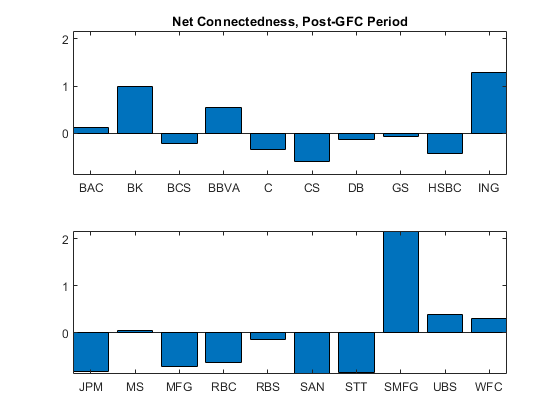

In [73]:
Maxval = NET_2;

subplot(211); ...
axval = NET_2;
a1 =subplot(211); ...
bar(Maxval(1:10)); axis([1,10, -1,1]);axis tight;...
title('Net Connectedness, Post-GFC Period');...
names = {'BAC';'BK';'BCS';'BBVA'; 'C'; 'CS'; 'DB'; 'GS'; 'HSBC'; 'ING'}; ...
set(gca,'xtick',[1:10],'xticklabel',names);...
a2 = subplot(212); ...
bar(Maxval(11:20)); axis([1,10,-1,1]); axis tight;...
names1 = {'JPM'; 'MS'; ,'MFG'; 'RBC'; 'RBS'; 'SAN'; 'STT'; 'SMFG'; 'UBS'; 'WFC'};
set(gca,'xtick',[1:10],'xticklabel',names1);
linkaxes([a1, a2], 'y');
saveas(gcf, 'BIS_NetConnect2.eps', 'eps');

In [76]:
VDD1 = VD_1';
VDD2 = VD_2';
adj2gephilab('BIS_NN20_1', VDD1);
adj2gephilab('BIS_NN20_2', VDD2 );

In the more complex network, DB, RCB, SAN and WFC stand out, as well as UBS.  BK is no longer a net transmitter.

Lets try a four layered network

In [13]:
tic
nnst = [20 15 10 5];
lagst = [1:5];
[VD2, INWARD2, OUTWARD2,NET2, IFCRIT2] = NNVARfun4(dat_, xx, nnst, lagst);
toc
runtime = toc/60



aif =

    2.3296


bif =

    9.3467

Elapsed time is 110.275928 seconds.

runtime =

    1.8379




In [14]:
[IFCRIT IFCRIT1 IFCRIT2]


ans =

    2.3296    2.1568    2.3296
    9.3467    8.6531    9.3467
    2.4262    2.2462    2.4262




This result shows that the four hidden layer network is worse than the other networks by all three criteria (AIC, BIC, HQIF). Here is what it looks like.

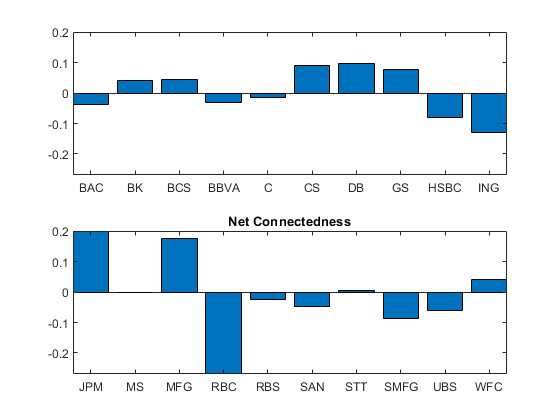

In [15]:
Maxval = NET2;

a1 =subplot(211); ...
bar(Maxval(1:10)); axis([1,10, -1,1]);axis tight;...
names = {'BAC';'BK';'BCS';'BBVA'; 'C'; 'CS'; 'DB'; 'GS'; 'HSBC'; 'ING'}; ...
set(gca,'xtick',[1:10],'xticklabel',names);...
a2 = subplot(212); ...
bar(Maxval(11:20)); axis([1,10,-1,1]); axis tight; title('Net Connectedness');...
names1 = {'JPM'; 'MS'; ,'MFG'; 'RBC'; 'RBS'; 'SAN'; 'STT'; 'SMFG'; 'UBS'; 'WFC'};
set(gca,'xtick',[1:10],'xticklabel',names1);
linkaxes([a1, a2], 'y');

DB stands out in all three, lets try an even more complex network.

In [16]:
tic
nnst = [25 20 15 10 5];
lagst = [1:5];
[VD3, INWARD3, OUTWARD3,NET3, IFCRIT3] = NNVARfun4(dat_, xx, nnst, lagst);
toc;
runtime = toc/60


aif =

    3.1446


bif =

   12.6188

Elapsed time is 132.421842 seconds.

runtime =

    2.2070




In [17]:
[IFCRIT IFCRIT1 IFCRIT2 IFCRIT3]


ans =

    2.3296    2.1568    2.3296    3.1446
    9.3467    8.6531    9.3467   12.6188
    2.4262    2.2462    2.4262    3.2751




Thus the network with three hidden layers [20 10 5], appears to be best, by all three criteria.  Let's examine the network connectedness.  We create nodes and edges for the Gephi software.

In [64]:
help adjgephilab

--- adjgephilab not found. Showing help for adj2gephilab instead. ---

  Convert ana adjacency matrix of a graph to 2 spreadhseets csv files
  one for the edge table and the other for node table.
  The files _node.csv and _edge.csv have to be open 
 in Gephi via Data Laboratory.
  INPUTS:
            filename: string for the prefix name of the two files .csv
            ADJ: the adjacency matrix
            parameters: vector as properties of the node to use as
                               attributes of them.
  OUTPUTS:
             two csv spreadsheet files: 
                        filename_node.csv
                        filename_edge.csv
              EdgeL = it returns the edge list corresponing to the
              adjacency matrix. (it can be saved to be open in Gephi too)
 
  The two files must be open in Gephi via the Data Laboratory




In [22]:
VDD1 = VD1'; 
VDD1;
NAMES = [names; names1];
NAMES
return;
NAMES1 = cell2table(NAMES);
NAMES2 = table2array(NAMES1);

%adj2gephilab('BIS_Range_NN',VDD1,'');
NAMES = BankNames'
G = digraph(VDD1, NAMES2, 'omitselfloops');
 G.Edges;
 LWidths = 3*G.Edges.Weight/max(G.Edges.Weight);
% plot(G,'EdgeLabel',G.Edges.Weight,'LineWidth',LWidths)
  p = plot(G, 'Layout', 'force', 'NodeLabelColor', 'k','NodeFontSize', 15, 'LineWidth',  LWidths,   'EdgeColor','b' );  
 p.ArrowSize = 5;
  p.Marker = 's';
p.NodeColor = 'r';
p = plot(G, 'Layout', 'force', 'UseGravity', true, 'NodeLabelColor', 'r','NodeFontSize', 12, 'LineWidth',  LWidths,   'EdgeColor','k' );


NAMES =

  20x1 cell array

    {'BAC' }
    {'BK'  }
    {'BCS' }
    {'BBVA'}
    {'C'   }
    {'CS'  }
    {'DB'  }
    {'GS'  }
    {'HSBC'}
    {'ING' }
    {'JPM' }
    {'MS'  }
    {'MFG' }
    {'RBC' }
    {'RBS' }
    {'SAN' }
    {'STT' }
    {'SMFG'}
    {'UBS' }
    {'WFC' }




In [19]:
save BIS_NN_Data;